In [1]:
import pandas as pd
import akshare as ak

# 800自由现金流，季度更新
# https://www.csindex.com.cn/#/indices/family/detail?indexCode=932368
stocks = [
'000039',
'000426',
'000513',
'000568',
'000651',
'000708',
'000792',
'000807',
'000858',
'000933',
'002001',
'002056',
'002120',
'002352',
'002532',
'002714',
'300002',
'300073',
'300498',
'300724',
'300803',
'600066',
'600096',
'600219',
'600258',
'600295',
'600312',
'600352',
'600380',
'600482',
'600585',
'600873',
'600938',
'600968',
'601156',
'601168',
'601212',
'601225',
'601231',
'601600',
'601877',
'601880',
'601919',
'603129',
'603233',
'603816',
'603833',
'603885',
'603939',
'603993'
]
# 一次性获取全市场 A 股实时行情
spot_df = ak.stock_zh_a_spot_em()

/home/jovyan/data/.venv/lib/python3.11/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


  0%|          | 0/57 [00:00<?, ?it/s]

In [2]:
# 只看我们关心的列
spot_df = spot_df[["代码", "名称", "流通市值"]]

# 过滤出你的股票
my_df = spot_df[spot_df["代码"].isin(stocks)]

In [3]:
def weekly_return(code):
    try:
        df = ak.stock_zh_a_hist(symbol=code, period="weekly", adjust="hfq")
        if len(df) >= 2:
            last_week_close = df.iloc[-2]["收盘"]
            this_week_close = df.iloc[-1]["收盘"]
            return round((this_week_close / last_week_close - 1) * 100, 2)
    except Exception as e:
        print(f"{code} 获取失败: {e}")
    return None

# 添加周涨幅
my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)

/tmp/ipykernel_19706/1229572994.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅(%)"] = my_df["代码"].apply(weekly_return)


In [4]:
my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)

# 综合得分（简单相加，也可以加权）
my_df["因子总分"] = my_df["市值_score"] + my_df["周涨幅_score"]

# 排序看前10个
result = my_df.sort_values("因子总分", ascending=False).head(10)
result

/tmp/ipykernel_19706/2716460985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["市值_score"] = pd.qcut(my_df["流通市值"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  my_df["周涨幅_score"] = pd.qcut(my_df["周涨幅(%)"], 5, labels=[5,4,3,2,1]).astype(int)
/tmp/ipykernel_19706/2716460985.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,代码,名称,流通市值,周涨幅(%),市值_score,周涨幅_score,因子总分
2822,600380,健康元,2.361824e+10,0.29,5,5,10
4930,603233,大参林,1.942875e+10,-1.13,5,5,10
4101,002120,韵达股份,2.426637e+10,-0.50,5,5,10
2363,000039,中集集团,1.887154e+10,0.42,5,5,10
2426,600312,平高电气,2.203640e+10,0.42,5,5,10
5104,603939,益丰药房,2.921389e+10,-1.65,4,5,9
4811,300002,神州泰岳,2.613494e+10,-1.12,4,5,9
3213,600873,梅花生物,3.143773e+10,0.08,4,5,9
1035,600295,鄂尔多斯,2.046697e+10,1.53,5,3,8
2676,603885,吉祥航空,2.782423e+10,0.44,4,4,8


In [5]:
import empyrical
import alphalens as al

In [12]:
import pandas as pd
import akshare as ak
from tqdm import tqdm
import datetime as dt
import alphalens as al

# 股票池
codes = ['000039','000426','000513','000568','000651','000708','000792','000807',
         '000858','000933','002001','002056','002120','002352','002532','002714',
         '300002','300073','300498','300724','300803','600066','600096','600219',
         '600258','600295','600312','600352','600380','600482','600585','600873',
         '600938','600968','601156','601168','601212','601225','601231','601600',
         '601877','601880','601919','603129','603233','603816','603833','603885',
         '603939','603993']

start = '2023-08-19'
end   = '2025-08-19'

tickers = codes

# ---------- 1. 拉后复权周 K ----------
def weekly_hfq(code):
    df = ak.stock_zh_a_hist(symbol=code, period="weekly",
                            start_date=start.replace('-', ''),
                            end_date=end.replace('-', ''),
                            adjust="hfq")
    # 统一列名为小写英文
    df = df.rename(columns=str.lower)          # Date -> date
    df = df.rename(columns={'日期': 'date',   # 中文兜底
                            '收盘': 'close'})
    df = df[['date', 'close']].copy()
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['code'] = code
    return df[['date', 'code', 'close']]

prices = []
for t in tqdm(tickers):
    prices.append(weekly_hfq(t))
prices = pd.concat(prices, ignore_index=True)

# 构造价格透视表：行=date, 列=code
prices_pivot = prices.pivot(index='date', columns='code', values='close')

100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


In [13]:
prices.to_parquet("data.parquet", engine="pyarrow", index=False)

code        000039  000426  000513  000568  000651  000708  000792  000807  \
date                                                                         
2020-08-28    0.91    2.61    4.37    9.90    2.82    3.58   -4.35    1.67   
2020-09-04    0.93    2.78    4.24   10.99    2.90    3.54   -5.66    1.60   
2020-09-11    0.91    2.64    3.94   10.22    2.89    3.46   -5.66    1.60   
2020-09-18    0.96    2.69    4.11   10.26    2.95    3.59   -5.66    1.66   
2020-09-25    0.91    2.45    4.09    9.94    2.88    3.31   -5.66    1.52   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2025-08-01    0.91    3.84    2.69    3.61    1.80    1.54    2.52    1.86   
2025-08-08    0.91    4.05    2.56    3.77    1.84    1.54    2.59    1.92   
2025-08-15    0.91    4.36    2.56    3.66    1.87    1.55    2.69    2.09   
2025-08-22    0.91    4.25    2.73    3.80    1.82    1.59    2.71    2.06   
2025-08-29    0.92    4.41    2.75    4.08    1.88    1.63    2.

,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-1.370382,-0.499691,-0.884324,0.177754,934,20.304348
2,-0.901124,-0.236978,-0.517449,0.120770,922,20.043478
3,-0.440780,0.130837,-0.196867,0.110282,916,19.913043
4,-0.230281,0.681542,0.190304,0.177573,910,19.782609
5,0.266648,6.158341,1.427234,1.283055,918,19.956522


Returns Analysis


,12D
Ann. alpha,-0.273
beta,0.438
Mean Period Wise Return Top Quantile (bps),149.780
Mean Period Wise Return Bottom Quantile (bps),342.810
Mean Period Wise Spread (bps),-193.031


<Figure size 640x480 with 0 Axes>

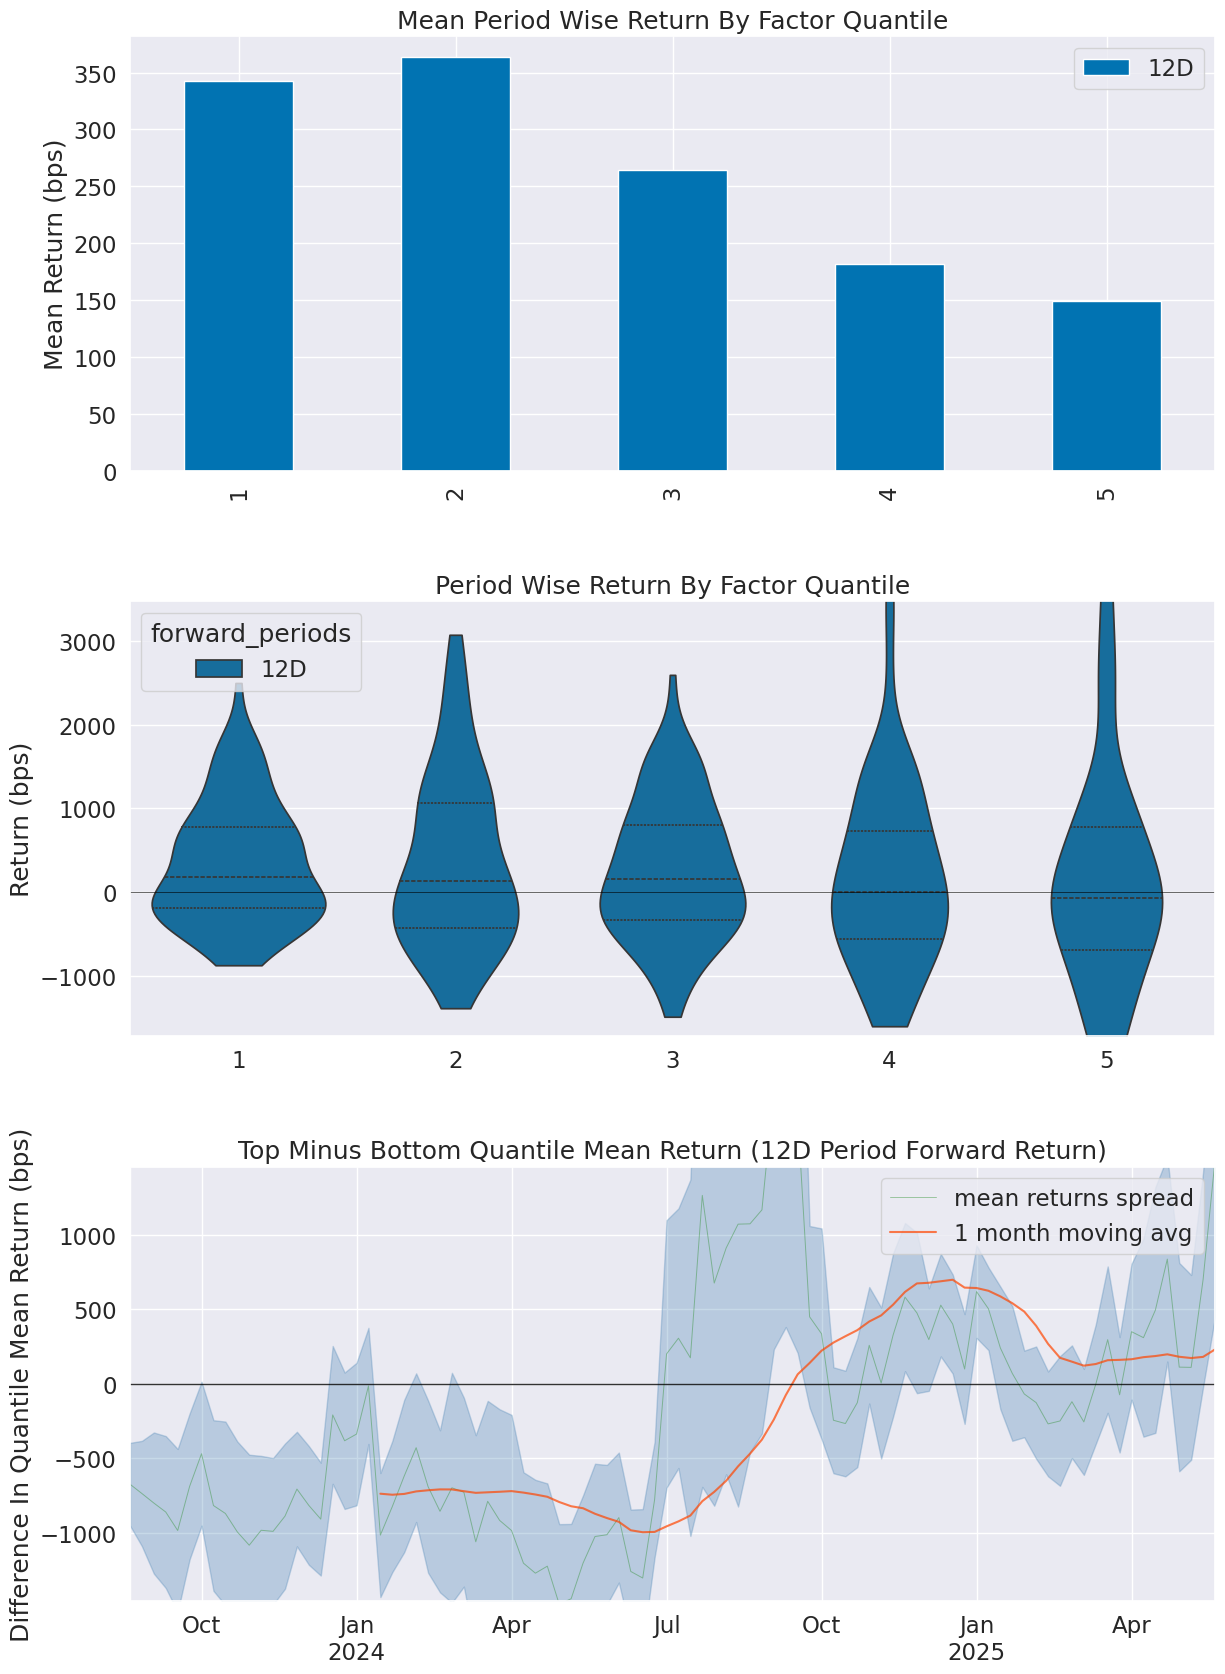

Information Analysis


,12D
IC Mean,-0.147
IC Std.,0.133
Risk-Adjusted IC,-1.107
t-stat(IC),-10.621
p-value(IC),0.000
IC Skew,0.401
IC Kurtosis,-0.422


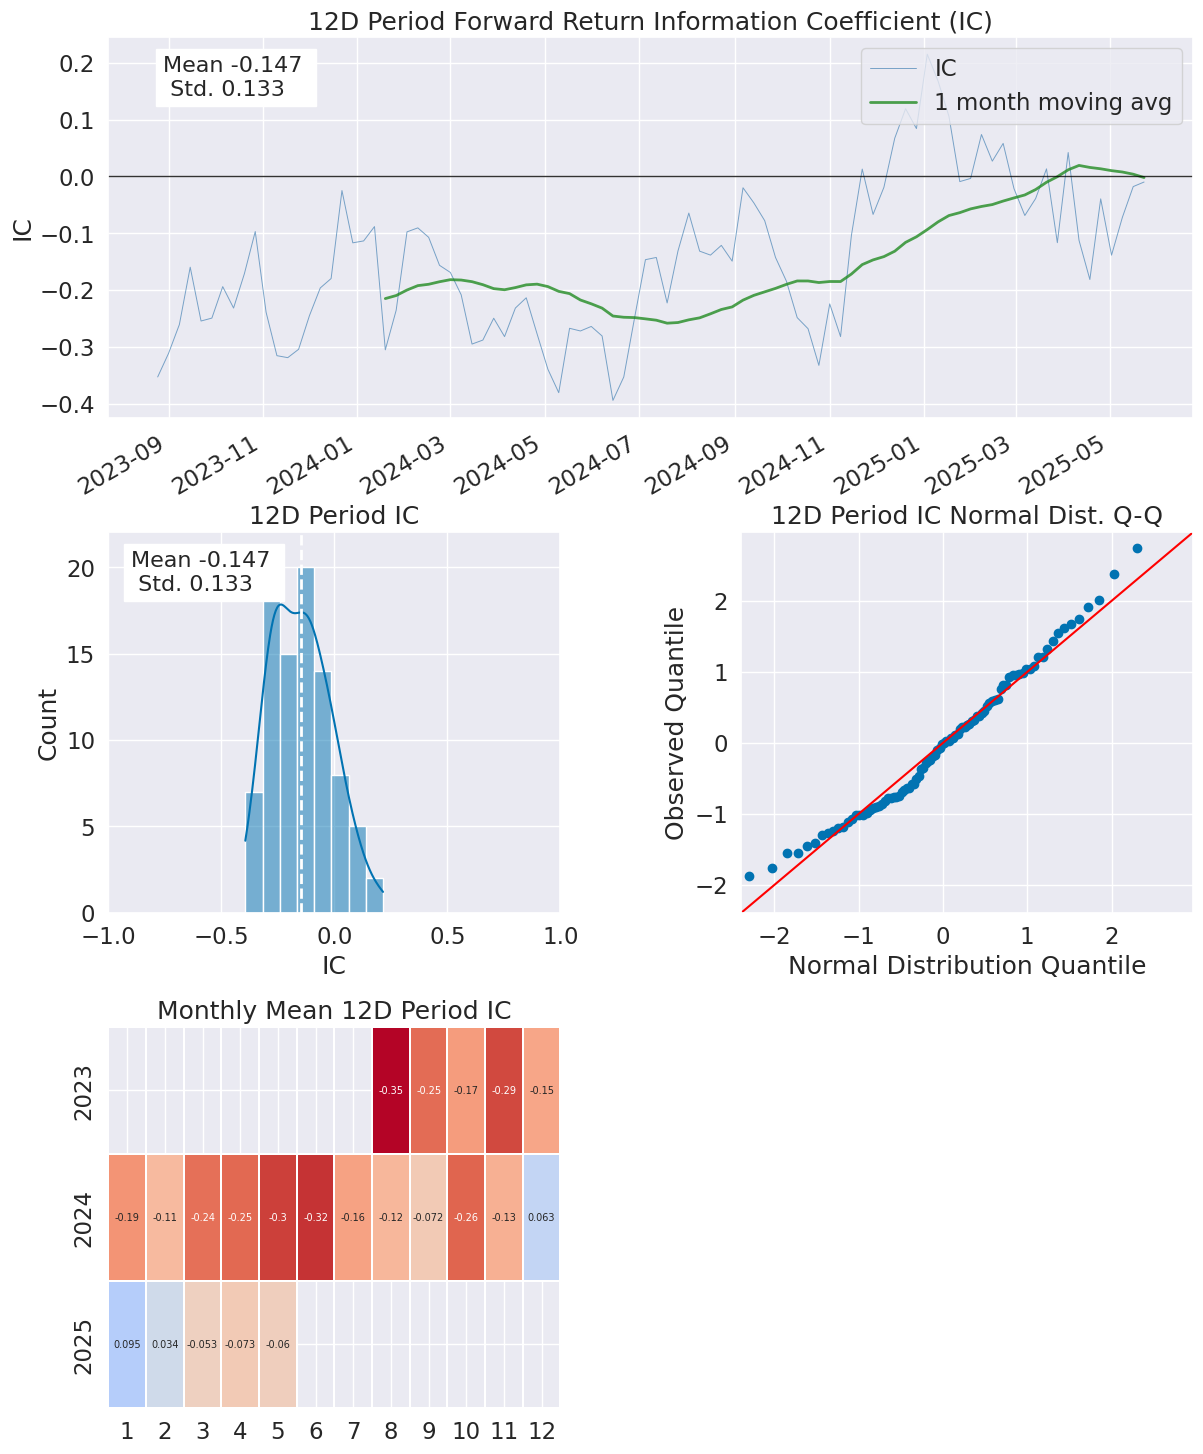

Turnover Analysis


,12D
Quantile 1 Mean Turnover,0.104
Quantile 2 Mean Turnover,0.310
Quantile 3 Mean Turnover,0.384
Quantile 4 Mean Turnover,0.314
Quantile 5 Mean Turnover,0.128


,12D
Mean Factor Rank Autocorrelation,0.963


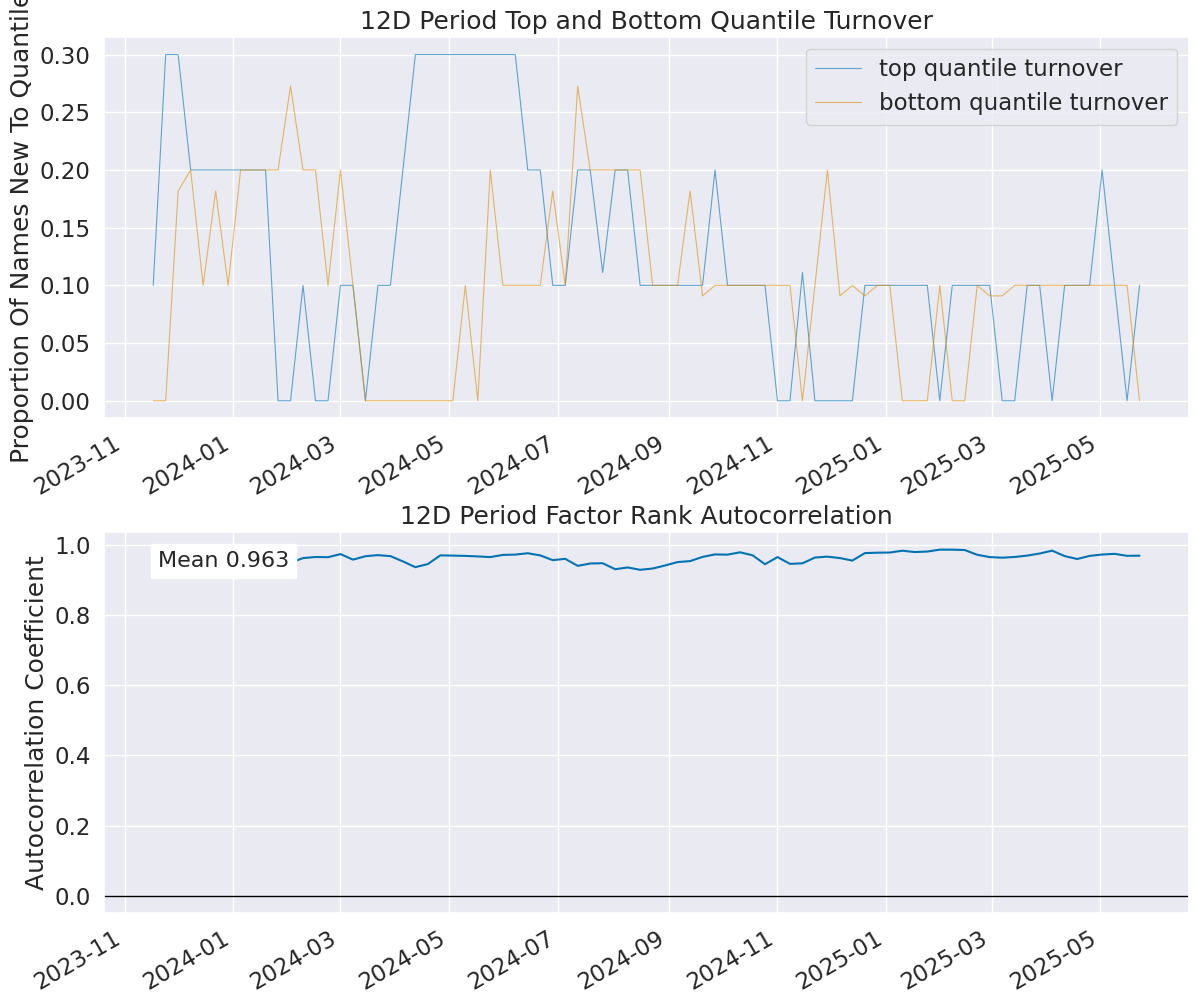

In [25]:
import pandas as pd
import numpy as np
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.tears import create_full_tear_sheet
import warnings
warnings.filterwarnings('ignore')

# 数据预处理
prices_df = pd.read_parquet("data.parquet", engine="pyarrow")
prices_df['date'] = pd.to_datetime(prices_df['date'])

# 转换为宽格式
price_pivot = prices_df.pivot(index='date', columns='code', values='close')
price_pivot.index = pd.to_datetime(price_pivot.index)
price_pivot = price_pivot.sort_index()
price_pivot = price_pivot.asfreq('W-FRI')

# 创建因子数据 - 使用当期价格作为因子
fatcors = pd.read_parquet("pb.parquet", engine="pyarrow")
factor_pivot = fatcors.pivot(index='date', columns='code', values='pb')  # 或者使用 price_pivot.shift(1) 作为滞后因子
factor_pivot_std = standardize_wide(factor_pivot)

def standardize_wide(df):
    def std_row(s):
        s_clip = s.clip(lower=s.quantile(0.01), upper=s.quantile(0.99))
        return (s_clip - s_clip.mean()) / (s_clip.std() or 1)
    return df.apply(std_row, axis=1)

factor_series = factor_pivot_std.stack()
factor_series.index.names = ['date', 'asset']
factor_series.name = 'factor'

print(f"数据时间范围: {price_pivot.index.min()} 到 {price_pivot.index.max()}")
print(f"股票数量: {len(price_pivot.columns)}")
print(f"交易周数: {len(price_pivot)}")

try:
    # 使用 alphalens 处理数据
    factor_data_clean = get_clean_factor_and_forward_returns(
        factor=factor_series,
        prices=price_pivot,
        periods=[12],  # 1周前瞻收益
        max_loss=0.80,
        quantiles=5
    )
    
    print("因子数据处理成功!")
    print(f"有效因子数据点: {len(factor_data_clean)}")
    
    # 创建完整的分析报告
    print("正在生成完整分析报告...")
    
    # 生成 full tear sheet
    create_full_tear_sheet(
        factor_data=factor_data_clean,
        long_short=False,
        group_neutral=False,
        by_group=False
    )
    
except Exception as e:
    print(f"生成报告时出错: {e}")
    import traceback
    traceback.print_exc()

In [69]:
price_cache = {}

print("开始下载股票价格数据...")
for code in stocks_to_fetch:
    try:
        # 转换 A 股代码格式（akshare 接口需要）
        df = ak.stock_zh_a_hist(symbol=code, period="daily", adjust="hfq")
        if df is not None and not df.empty:
            df['date'] = pd.to_datetime(df['日期'])
            df['close'] = pd.to_numeric(df['收盘'], errors='coerce')
            price_cache[code] = df[['date', 'close']].set_index('date')['close'].sort_index()
        else:
            price_cache[code] = pd.Series(dtype=float)
    except Exception as e:
        print(f"获取 {code} 数据失败: {e}")
        price_cache[code] = pd.Series(dtype=float)
print("价格数据下载完成！")

开始下载股票价格数据...
价格数据下载完成！


In [74]:
import akshare as ak
import pandas as pd
import numpy as np
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# Step 1: 加载并处理 PB 数据（同上）
# -------------------------------
fatcors = pd.read_parquet("pb.parquet", engine="pyarrow")
fatcors = fatcors[fatcors['pb'] > 0]

fatcors['date'] = pd.to_datetime(fatcors['date'])
fatcors['quarter'] = fatcors['date'].dt.to_period('Q')

# 取每个股票每个季度的最后一个交易日记录（季度末 PB）
idx = fatcors.groupby(['code', 'quarter'])['date'].idxmax()
quarterly_pb = fatcors.loc[idx][['code', 'quarter', 'pb', 'date']]

# 每个季度选出 PB 最低的 10 只股票
def get_top10_lowpb(group):
    return group.nsmallest(10, 'pb')

selected_stocks = quarterly_pb.groupby('quarter').apply(get_top10_lowpb).reset_index(drop=True)

# 添加：计算下一个季度的起止时间（用于回测持有期）
selected_stocks['next_quarter'] = selected_stocks['quarter'] + 1
selected_stocks['next_quarter_start'] = selected_stocks['next_quarter'].dt.start_time.dt.date
selected_stocks['next_quarter_end'] = selected_stocks['next_quarter'].dt.end_time.dt.date

# 删除中间列（可选）
selected_stocks.drop(columns=['next_quarter'], inplace=True)
# 去重，避免重复下载（可选）
stocks_to_fetch = selected_stocks['code'].unique()

# -------------------------------
# Step 2: 使用 akshare 批量获取价格数据（缓存机制更佳）
# -------------------------------

In [75]:
selected_stocks

,code,quarter,pb,date,next_quarter_start,next_quarter_end
0,600219,2020Q3,0.69,2020-09-25,2020-10-01,2020-12-31
1,000039,2020Q3,0.91,2020-09-25,2020-10-01,2020-12-31
2,600295,2020Q3,1.02,2020-09-25,2020-10-01,2020-12-31
3,601600,2020Q3,1.02,2020-09-25,2020-10-01,2020-12-31
4,600312,2020Q3,1.06,2020-09-25,2020-10-01,2020-12-31
...,...,...,...,...,...,...
205,601919,2025Q3,1.01,2025-08-29,2025-10-01,2025-12-31
206,002120,2025Q3,1.22,2025-08-29,2025-10-01,2025-12-31
207,601877,2025Q3,1.23,2025-08-29,2025-10-01,2025-12-31
208,600295,2025Q3,1.35,2025-08-29,2025-10-01,2025-12-31


In [76]:
# 存储每笔交易的收益率
returns = []

# 定义一个函数：获取某只股票在某时间段的收益率
def get_holding_return(code, start_date, end_date):
    if code not in price_cache:
        return np.nan
    prices = price_cache[code]
    if prices.empty:
        return np.nan

    # 查找最接近 start_date 和 end_date 的价格
    try:
        buy_price = prices.loc[prices.index >= pd.to_datetime(start_date)].iloc[0]
        sell_price = prices.loc[prices.index <= pd.to_datetime(end_date)].iloc[-1]
        ret = (sell_price - buy_price) / buy_price
        return ret
    except IndexError:
        return np.nan  # 价格缺失

# 向量化：对每条选中记录计算下个季度的收益
for _, row in selected_stocks.iterrows():
    code = row['code']
    start = row['next_quarter_start']
    end = row['next_quarter_end']
    ret = get_holding_return(code, start, end)
    returns.append(ret)

selected_stocks['return'] = returns

In [77]:
# 去除无效收益
valid_returns = selected_stocks.dropna(subset=['return'])

print(f"\n=== 回测统计 ===")
print(f"总交易次数: {len(valid_returns)}")
print(f"平均季度收益率: {valid_returns['return'].mean():.2%}")
print(f"年化收益率 (粗略): {(1 + valid_returns['return'].mean())**4 - 1:.2%}")
print(f"胜率: {(valid_returns['return'] > 0).mean():.2%}")
print(f"收益标准差: {valid_returns['return'].std():.2%}")
print(f"夏普比率 (无风险利率=0): {valid_returns['return'].mean() / valid_returns['return'].std() * np.sqrt(4):.2f}")

# 按季度统计平均收益
quarterly_perf = valid_returns.groupby('quarter')['return'].agg(['mean', 'count']).rename(columns={'mean': 'avg_return', 'count': 'n_stocks'})
quarterly_perf['avg_return'] = quarterly_perf['avg_return'].round(4)


=== 回测统计 ===
总交易次数: 200
平均季度收益率: 3.23%
年化收益率 (粗略): 13.54%
胜率: 52.00%
收益标准差: 11.80%
夏普比率 (无风险利率=0): 0.55


In [78]:
import matplotlib.pyplot as plt
import numpy as np

# ========================
# 1. 计算最大回撤
# ========================

# 提取每季度的平均收益
returns_series = quarterly_perf['avg_return']

# 构建净值曲线（从 1.0 开始）
net_value = (1 + returns_series).cumprod()

# 累计最大值（运行高点）
peak = net_value.expanding().max()

# 回撤 = (当前净值 - 历史最高) / 历史最高
drawdown = (net_value - peak) / peak

# 最大回撤
max_drawdown = drawdown.min()

# 年化指标补充
annual_return = (net_value.iloc[-1]) ** (4 / len(net_value)) - 1  # 几何年化
annual_volatility = returns_series.std() * np.sqrt(4)
sharpe_ratio = (returns_series.mean() / returns_series.std()) * np.sqrt(4) if returns_series.std() != 0 else np.inf
calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else np.inf

print(f"\n=== 风险与回撤指标 ===")
print(f"年化收益率 (几何): {annual_return:.2%}")
print(f"年化波动率: {annual_volatility:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"Calmar 比率 (年化收益/最大回撤): {calmar_ratio:.2f}")


=== 风险与回撤指标 ===
年化收益率 (几何): 12.68%
年化波动率: 13.20%
夏普比率: 0.98
最大回撤: -15.82%
Calmar 比率 (年化收益/最大回撤): 0.80


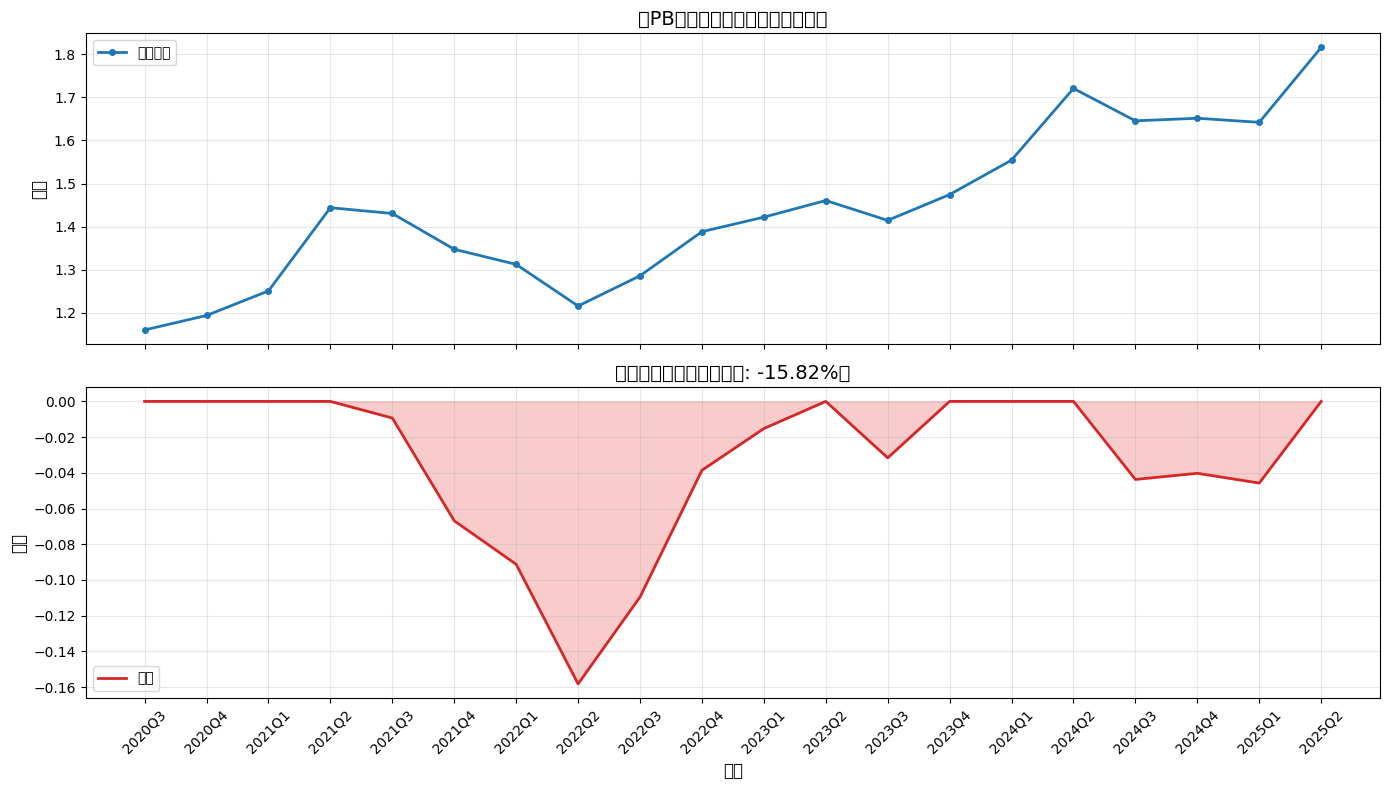

In [79]:
# ========================
# 2. 绘图：净值曲线 + 回撤
# ========================
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# 净值曲线
axes[0].plot(net_value.index.astype(str), net_value.values, label='净值曲线', color='tab:blue', linewidth=2, marker='o', markersize=4)
axes[0].set_title('低PB策略净值曲线（季度再平衡）', fontsize=14)
axes[0].set_ylabel('净值', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# 回撤曲线
axes[1].plot(drawdown.index.astype(str), drawdown.values, label='回撤', color='tab:red', linewidth=2)
axes[1].fill_between(drawdown.index.astype(str), drawdown.values, 0, color='lightcoral', alpha=0.4)
axes[1].set_title(f'策略回撤曲线（最大回撤: {max_drawdown:.2%}）', fontsize=14)
axes[1].set_ylabel('回撤', fontsize=12)
axes[1].set_xlabel('季度', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

# 旋转 x 轴标签
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [112]:
import pandas as pd
import numpy as np

# 设置时间范围：最近5年
today = pd.Timestamp.now()
five_years_ago = today - pd.DateOffset(years=5)

# ========================
# 1. 从 price_cache 构建周频数据，并限制为近5年
# ========================
rows = []
for code, series in price_cache.items():
    if series.empty:
        continue
    
    # 过滤近5年
    series = series[series.index >= five_years_ago]
    if len(series) < 10:
        continue
    
    # 转周频
    weekly = series.resample('W').last()  # 返回 Series
    df = weekly.to_frame(name='close').reset_index()  # 强制重置 index
    df['code'] = code
    rows.append(df)

# 合并后，重新设置一个干净的整数索引 或 用 (date, code) 多重索引
full_df = pd.concat(rows, ignore_index=True)  # ✅ 关键：ignore_index=True

# 然后设置 date 为索引（但确保唯一）
full_df['date'] = pd.to_datetime(full_df['date'])
full_df.sort_values(['code', 'date'], inplace=True)

# ✅ 方法一：使用整数索引（推荐）
# full_df.set_index('date', inplace=True)  # 不设为索引，避免 reindex 冲突

# ✅ 方法二：使用多重索引（更安全）
full_df.set_index(['date', 'code'], inplace=True)

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ========================
# 配置参数
# ========================
YEARS = 5
MOMENTUM_WEEKS = 12
MIN_MOMENTUM = -0.3  # 过去12周跌幅不超过50%
TOP_N = 12

# 时间范围
today = pd.Timestamp.now()
start_date = today - pd.DateOffset(years=YEARS)

# ========================
# Step 1: 从 price_cache 构建 full_df（近5年，避免重复索引）
# ========================
rows = []
for code, series in price_cache.items():
    if series.empty:
        continue
    # 过滤时间
    series = series[series.index >= start_date]
    if len(series) < 10:
        continue
    # 转为周频：取每周最后一个交易日
    weekly = series.resample('W').last()  # 得到 Series
    df = weekly.to_frame(name='close').reset_index()
    df.columns = ['date', 'close']
    df['code'] = code
    rows.append(df)

# 合并并重置索引，避免 duplicate label 问题
if not rows:
    raise ValueError("❌ 无有效价格数据（近5年）")

full_df = pd.concat(rows, ignore_index=True)
full_df['date'] = pd.to_datetime(full_df['date'])
full_df.sort_values(['code', 'date'], inplace=True)

# 添加 week 标签
full_df['week'] = full_df['date'].dt.to_period('W')

# ========================
# Step 2: 计算周收益 & 12周动量（向量化）
# ========================
# 排序确保 shift 正确
full_df.sort_values(['code', 'date'], inplace=True)

# 周收益
full_df['return'] = full_df.groupby('code')['close'].pct_change()
full_df.dropna(subset=['return'], inplace=True)

# 12周前价格 → 12周动量
full_df['close_12w_ago'] = full_df.groupby('code')['close'].shift(MOMENTUM_WEEKS)
full_df['momentum_12w'] = (full_df['close'] / full_df['close_12w_ago']) - 1

# 动量过滤：排除过去12周跌幅超过50%的股票
filtered_df = full_df[full_df['momentum_12w'] > MIN_MOMENTUM].copy()

# ========================
# Step 3: 每周选出“当周涨幅最低的10只股票”
# ========================
# 确保每周每只股票只保留一条（取最后一天）
weekly_data = filtered_df.groupby(['week', 'code']).last().reset_index()

# 每周选涨幅最小的10只
def select_lowest_10(group):
    return group.nsmallest(TOP_N, 'return')

selected_weekly = weekly_data.groupby('week').apply(select_lowest_10)
selected_weekly = selected_weekly.reset_index(drop=True)

# ========================
# Step 4: 向量化获取“下一周收益”
# ========================
#  确保 weekly_data 是普通 DataFrame（code, week 是列）
weekly_data_flat = weekly_data.reset_index()  # 确保 code 和 week 是列

# selected_with_next 的 week 必须是列（不是索引）
selected_with_next = selected_weekly[['code', 'week']].copy()  # 这里 week 是列
selected_with_next['next_week'] = selected_with_next['week'] + 1

# 合并：找这些股票在“下一周”的收益
future_returns = pd.merge(
    selected_with_next,
    weekly_data_flat[['code', 'week', 'return']],
    left_on=['code', 'next_week'],
    right_on=['code', 'week'],
    how='left'
).rename(columns={'return': 'future_return'})

future_returns = future_returns.rename(columns={'week_x': 'week'})

# 删除 week_y（它是 next_week 的副本）
future_returns = future_returns.drop(columns=['week_y'])

In [149]:
# ========================
# Step 5: 按买入周统计收益
# ========================
strategy_return = future_returns.groupby('week')['future_return'].mean().dropna()

# 净值曲线
net_value = (1 + strategy_return).cumprod()

# 最大回撤
peak = net_value.expanding().max()
drawdown = (net_value - peak) / peak
max_drawdown = drawdown.min()

# 年化指标
annual_return = (1 + strategy_return.mean()) ** 52 - 1
weekly_volatility = strategy_return.std()
sharpe_ratio = (strategy_return.mean() / weekly_volatility) * np.sqrt(52)  # ✅ 52周
win_rate = (strategy_return > 0).mean()
max_drawdown = drawdown.min()

# 输出
print("\n" + "="*40)
print("       策略回测结果（近5年）")
print("="*40)
print(f"回测周期: {start_date.date()} ~ {today.date()}")
print(f"总周数: {len(strategy_return)}")
print(f"平均周收益: {strategy_return.mean():.2%}")
print(f"年化收益率: {annual_return:.2%}")
print(f"胜率: {win_rate:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"夏普比率: {sharpe_ratio:.2f}")


       策略回测结果（近5年）
回测周期: 2020-08-26 ~ 2025-08-26
总周数: 228
平均周收益: 0.30%
年化收益率: 16.61%
胜率: 53.51%
最大回撤: -16.05%
夏普比率: 0.80


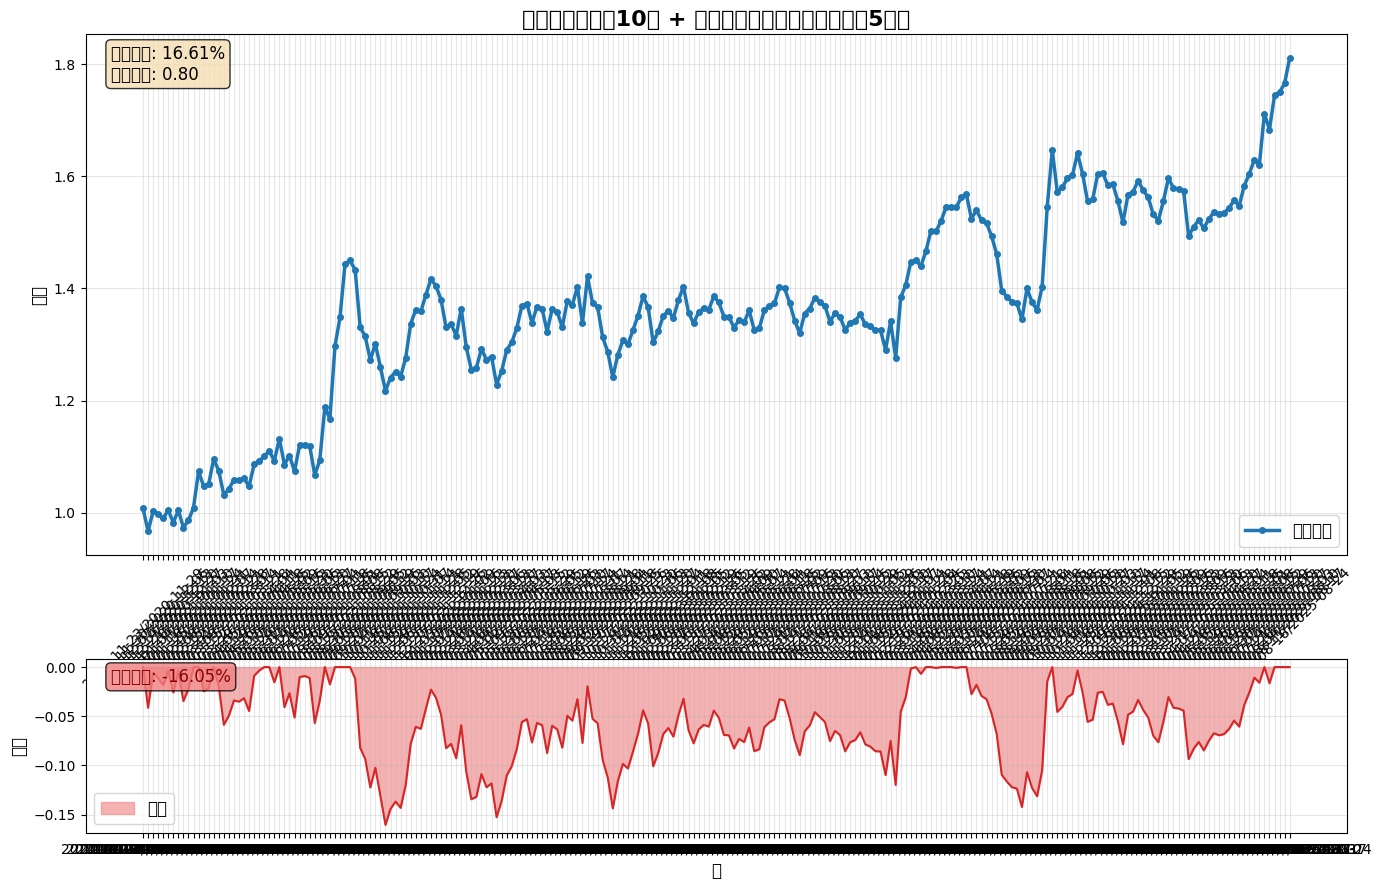

In [150]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

# ========================
# Step 6: 绘制净值曲线 + 回撤
# ========================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 9), gridspec_kw={'height_ratios': [3, 1]})

# 净值曲线
net_value.index = net_value.index.astype(str)  # Period → str 便于绘图
ax1.plot(net_value.index, net_value.values, 
         label='策略净值', color='tab:blue', linewidth=2.5, marker='o', markersize=4)
ax1.set_title('「每周涨幅最低10股 + 动量过滤」策略净值曲线（近5年）', fontsize=16, fontweight='bold')
ax1.set_ylabel('净值', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# 旋转x轴标签
ax1.tick_params(axis='x', rotation=45)

# 在图上标注年化收益和最大回撤
ax1.text(0.02, 0.98, f"年化收益: {annual_return:.2%}\n夏普比率: {sharpe_ratio:.2f}", 
         transform=ax1.transAxes, fontsize=12,
         bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
         verticalalignment='top')

# -----------------------
# 回撤曲线
# -----------------------
drawdown.index = drawdown.index.astype(str)
ax2.fill_between(drawdown.index, drawdown.values, 0, 
                 color='lightcoral', alpha=0.6, label='回撤')
ax2.plot(drawdown.index, drawdown.values, color='tab:red', linewidth=1.5)
ax2.set_ylabel('回撤', fontsize=12)
ax2.set_xlabel('周', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=12)

# 标注最大回撤
max_dd = drawdown.min()
ax2.text(0.02, 0.95, f"最大回撤: {max_dd:.2%}", 
         transform=ax2.transAxes, fontsize=12,
         bbox=dict(boxstyle="round", facecolor="lightcoral", alpha=0.8),
         verticalalignment='top', color='darkred')

# 优化布局
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)  # 子图间距
plt.show()